# value iteration 

This entire notebook was used during development steps, and only contains snippets of useful code. It will offer very little insight by reading it. It wont be commented, and I have only left it here since it is useful to take apart certain functions which appear in other parts of this repository. 

In [17]:
import numpy as np 
from typing import Callable

In [ ]:
len_x, len_y = 10, 10

## SPECIALISED FOR EX 9.27

In [3]:
def Value_iteration(S:list[tuple], # states
                    A:tuple,       # actions
                    P:list,        # probabilities
                    R:list,         # rewards
                    cutoff:int = 1000, 
                    discount_rate:float=0.8):
    # we assign V0[s] arbitrarily to start with
    V0 = np.zeros(2) #np.random.rand(len(S))  # Ensures values are float
    V_k = V0.astype(float)  
    k = 0
    pi = [0,0]
    while k < cutoff:
        V_k_minus_1 = V_k
        for index, state in enumerate(S):
            possible_values = [R[index][a] + discount_rate * (P[index][a]*V_k_minus_1[0] + (1-P[index][a])*V_k_minus_1[1]) for a in range(len(A))]
            V_k[index] = max(possible_values).astype(float)
        k += 1

    for index, state in enumerate(S):
        possible_values =  [R[index][a] + discount_rate * (P[index][a]*V_k_minus_1[0] + (1-P[index][a])*V_k_minus_1[1]) for a in range(len(A))]
        pi[index] =  possible_values.index(max(possible_values))

    return V_k, pi


###############################################
############# FUNCTION CALL ###################
###############################################

States = ('healthy', 'sick')
Actions = ('Relax', 'Party')
# we will be taking 0 to be healthy and 1 to be sick in terms of state
# and we will be using 0 for relax, and 1 to party 

Probabilities = [[0.95, # if healthy and relax
                 0.7],  # if healthy and party
                [ 0.5,  # if sick and relax
                 0.1]]  # if sick and party

Rewards = [[7, # if healthy and relax
            10],  # if healthy and party
            [0,  # if sick and relax
            2]]  # if sick and party

values, policies = Value_iteration(States, Actions, Probabilities, Rewards)

print('We determine the optimal policy to be:')
for index, value in enumerate(policies):
    print(f'if {States[index]}, then {Actions[value]}')

We determine the optimal policy to be:
if healthy, then Party
if sick, then Relax


## SPECIALISED FOR EX 9.28

In [26]:
def bellman_equation(actions, state, probabilities, V, rewards, discount_factor):
    values = []
    i, j = state  # coords
    corners = [(0, 0), (0, len(V) - 1), (len(V) - 1, 0), (len(V) - 1, len(V) - 1)]
    
    for intended_action in actions:
        # this inner for loop should be maximising over all intended actions to tell you which is the best
        summation_term = 0
        
        for possible_action in actions:
            probability_of_occurence = probabilities[0] if possible_action == intended_action else probabilities[1]
            
            # check where we are, and if this is within the grid
            new_i, new_j = i + possible_action[0], j + possible_action[1]
            
            if 0 <= new_i < len(V) and 0 <= new_j < len(V[0]):
                reward = rewards[i, j]  # Immediate reward 
                
                if reward != 0:  # if you are on a reward cell/ move into one, teleport to random corner
                    future_value = sum(V[corner] for corner in corners) / 4  
                else:
                    future_value = V[new_i, new_j]  # non special transition
            else:
                # stay in place and apply wall penalty if you hit wall 
                # print('this is triggered')
                reward = -1
                future_value = V[i, j]
            summation_term += probability_of_occurence * (reward + discount_factor * future_value)
        
        values.append(summation_term)  
    
    return max(values) # only return max value, not all of them 


In [66]:
def Value_iteration(S:np.ndarray, # states
                    A:tuple,       # actions
                    P:list,        # probabilities
                    R:list,         # rewards
                    cutoff:int = 1000, 
                    discount_rate:float=0.8):
    
    # we assign V0[s] arbitrarily to start with
    V0 = np.zeros(S.shape) 
    V_k = V0.astype(float)  
    k = 0
    pi = np.zeros(S.shape) 
    while k < cutoff:
        V_k_minus_1 = V_k.copy()
        
        for (i, j), value in np.ndenumerate(S):
            V_k[i][j] = bellman_equation(A, (i,j), P, V_k_minus_1, R, discount_rate)
        k += 1

    return np.round(V_k, decimals=1)

In [72]:
states = np.zeros((10, 10))

actions = [(1, 0),    # right
           (-1, 0),   # left
           (0, 1),    # up
           (0, -1)]   # down

probabilities = [0.7, 0.1]

rewards = np.zeros((10,10))
rewards[8][7] = 10
rewards[7][2] = 3
rewards[3][4] = -5
rewards[3][7] = -10

output = Value_iteration(S = states, 
                A = actions, 
                P = probabilities, 
                R = rewards, 
                cutoff=1000,
                discount_rate=0.9)

In [73]:
print(output.T)

[[ 0.9  1.4  1.7  2.   2.5  2.9  3.5  4.   3.6  3. ]
 [ 1.3  1.7  2.1  2.5  3.   3.6  4.2  4.9  4.3  3.7]
 [ 1.5  1.9  2.3  2.8  3.4  4.1  5.   6.   5.1  4.5]
 [ 1.4  1.8  2.1  2.4  3.4  4.1  4.8  5.6  6.   5.4]
 [ 1.4  1.8  1.8 -2.   3.5  4.6  5.5  6.4  7.2  6.5]
 [ 1.7  2.1  2.6  3.2  4.5  5.5  6.5  7.6  8.7  7.7]
 [ 1.6  2.1  2.5  3.1  5.1  6.4  7.6  9.  10.6  9.1]
 [ 1.5  1.8  1.4 -7.   4.7  7.   8.7 10.6 13.  10.7]
 [ 1.7  2.1  2.6  3.2  5.1  6.4  7.6  9.  10.6  9.1]
 [ 1.7  2.3  2.9  3.6  4.5  5.4  6.5  7.6  8.8  7.7]]


In [36]:
V0 = np.zeros(states.shape) 
V = V0.astype(float)  
discount_factor = 0.9
values = []
i, j = (8,7)

corners = [(0, 0), (0, len(V) - 1), (len(V) - 1, 0), (len(V) - 1, len(V) - 1)]

for intended_action in actions:
    # this inner for loop should be maximising over all intended actions to tell you which is the best
    summation_term = 0
    
    for possible_action in actions:
        probability_of_occurence = probabilities[0] if possible_action == intended_action else probabilities[1]
        
        # check where we are, and if this is within the grid
        new_i, new_j = i + possible_action[0], j + possible_action[1]
        
        if 0 <= new_i < len(V) and 0 <= new_j < len(V[0]):
            reward = rewards[i, j]  # Immediate reward 
            
            if reward != 0:  # if you are on a reward cell/ move into one, teleport to random corner
                future_value = sum(V[corner] for corner in corners) / 4  
            else:
                future_value = V[new_i, new_j]  # non special transition
        else:
            # stay in place and apply wall penalty if you hit wall 
            # print('this is triggered')
            reward = -1
            future_value = V[i, j]
        summation_term += probability_of_occurence * (reward + discount_factor * future_value)
    
    values.append(summation_term)  
    

## probabilities

In [3]:
def populate_probabilities_rewards(state, actions):
    sub_dirs = {}
    for index, _ in enumerate(actions):
        sub_dirs[index] = {}
        for corner in corners:
            sub_dirs[index][(corner)] = 0.25
    return sub_dirs

def populate_probabilities_usual(state, actions):
    sub_dirs = {}
    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}
        for actual_move in actions:
            value = 0.7 if intended_move == actual_move else 0.1
            sub_dirs[index][(state[0] + actual_move[0], state[1] + actual_move[1])] = value
    return sub_dirs

def populate_probabilities_edge(state, actions):
    sub_dirs = {}

    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}

        for actual_move in actions:
            new_row = state[0] + actual_move[0]
            new_col = state[1] + actual_move[1]

            # Check if out of bounds
            if (new_row < 0 or new_row >= len_x or
                new_col < 0 or new_col >= len_y):
                # Remain in the same cell 
                new_state = state
            else:
                new_state = (new_row, new_col)

            value = 0.7 if intended_move == actual_move else 0.1
            sub_dirs[index][new_state] = value

    return sub_dirs

In [4]:
def populate_positive_rewards(state, actions, reward_value):
    sub_dirs = {}
    for index, _ in enumerate(actions):
        sub_dirs[index] = {}
        for corner in corners:
            sub_dirs[index][(corner)] = reward_value
    return sub_dirs

def populate_negative_rewards(state, actions, reward_value):
    sub_dirs = {}
    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}
        for actual_move in actions:
            sub_dirs[index][(state[0] + actual_move[0], state[1] + actual_move[1])] = reward_value
    return sub_dirs

def populate_edge_penalties(state, actions):
    sub_dirs = {}

    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}

        for actual_move in actions:
            new_row = state[0] + actual_move[0]
            new_col = state[1] + actual_move[1]

            # Check if out of bounds
            if (new_row < 0 or new_row >= len_x or
                new_col < 0 or new_col >= len_y):
                # Remain in the same cell 
                new_state = state
            else:
                new_state = (new_row, new_col)

            value = -1 if new_state == state else 0
            sub_dirs[index][new_state] = value

    return sub_dirs

In [5]:
len_x, len_y = 10, 10

states = [(i, j) for i in range(len_x) for j in range(len_y)]
probabilities = {}

corners = [(0, 0), (0, len_y - 1), (len_x - 1, 0), (len_x - 1, len_y - 1)]
reward_states = [(8,7), (7,2), (3,4), (3,7)]
reward_values = [10, 3, -5, -10]

actions = [(1, 0),    # right
           (-1, 0),   # left
           (0, 1),    # up
           (0, -1)]   # down

In [6]:
for state in states:
    i, j = state
    if state in reward_states and reward_values[reward_states.index(state)] > 0:
        # teleportation step
        probabilities[state] = populate_probabilities_rewards(state, actions)
    elif 0 < i < len_x-1 and 0 < j < len_y-1:
        # we are in standard operating conditions, make usual sub directories
        probabilities[state] = populate_probabilities_usual(state, actions)
    else: # we must be at an edge
        probabilities[state] = populate_probabilities_edge(state, actions)

In [8]:
rewards = {}
for state in states:
    i, j = state
    if state in reward_states and reward_values[reward_states.index(state)] > 0:
        # we are about to teleport
        rewards[state] = populate_positive_rewards(state, actions, reward_values[reward_states.index(state)])
    elif state in reward_states and reward_values[reward_states.index(state)] < 0:
        # we get a reward but do not teleport
        rewards[state] = populate_negative_rewards(state, actions, reward_values[reward_states.index(state)])
    elif i in [0, len_x-1] or j in [0, len_y-1]:
        rewards[state] = populate_edge_penalties(state, actions)

In [10]:
from MDP import GenericMDP
import numpy as np
mdp_solver = GenericMDP(states, actions, probabilities, rewards, 0.9, 200, len_x=len_x, len_y=len_y, reward_list=reward_states, reward_values= reward_values, problem_type='gridworld')

In [7]:
# we need to make the objects for rewards and actions for the states for ex 9.27
states = ['Healthy', 'Sick']
actions = ['Relax', 'Party']
probabilities = {}
if len(states) == 2:
    for s in states: 
        temp = {}
        for index, action in enumerate(actions):
            temp2 = {}
            probability = input(f'if in state = {s} and you take action = {action}, what is the probability of entering state = {states[0]}')
            print(f'Defaulting to probability = {(1-float(probability.strip())):.3f} for transition {s} to {states[1]} following action {action}')
            temp2[states[0]] = float(probability.strip())
            temp2[states[1]] = (1-float(probability.strip()))
            temp[index] = temp2
        probabilities[s] = temp
else:
    for s in states: 
        temp = {}
        for index, action in enumerate(actions):
            temp2 = {}
            for s_prime in states:
                probability = input(f'if in state = {s} and you take action = {action}, what is the probability of entering state = {s_prime}')
                temp2[s_prime] = float(probability.strip())
            temp[index] = temp2
        probabilities[s] = temp


Defaulting to probability = 0.050 for transition Healthy to Sick following action Relax
Defaulting to probability = 0.300 for transition Healthy to Sick following action Party
Defaulting to probability = 0.500 for transition Sick to Sick following action Relax
Defaulting to probability = 0.900 for transition Sick to Sick following action Party


In [8]:
# next we do the rewards
rewards = {}
if len(actions) == 2:
    for s in states: 
        temp = {}
        for index, action in enumerate(actions):
            temp2 = {}
            reward = input(f'if in state = {s} and you take action = {action}, what is the reward given?')
            
            temp2[states[0]] = float(reward)
            temp2[states[1]] = float(reward)
            temp[index] = temp2
        rewards[s] = temp

Tolerance of 1e-06 was met after 116 iterations. Terminating now.


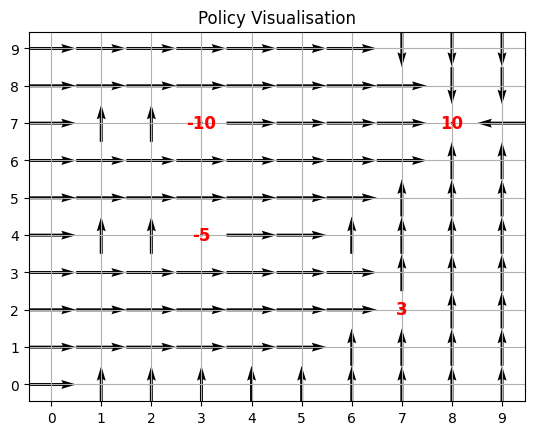

In [11]:
#mdp_solver = GenericMDP(states, actions, probabilities, rewards, 0.8, 200)
policy, values = mdp_solver()

In [15]:
for key in values:
    values[key] = round(values[key],3)

In [16]:
values

{(0, 0): np.float64(0.902),
 (0, 1): np.float64(1.264),
 (0, 2): np.float64(1.409),
 (0, 3): np.float64(1.326),
 (0, 4): np.float64(1.375),
 (0, 5): np.float64(1.612),
 (0, 6): np.float64(1.615),
 (0, 7): np.float64(1.439),
 (0, 8): np.float64(1.648),
 (0, 9): np.float64(1.572),
 (1, 0): np.float64(1.282),
 (1, 1): np.float64(1.654),
 (1, 2): np.float64(1.823),
 (1, 3): np.float64(1.677),
 (1, 4): np.float64(1.726),
 (1, 5): np.float64(2.06),
 (1, 6): np.float64(2.056),
 (1, 7): np.float64(1.77),
 (1, 8): np.float64(2.109),
 (1, 9): np.float64(2.194),
 (2, 0): np.float64(1.594),
 (2, 1): np.float64(2.001),
 (2, 2): np.float64(2.217),
 (2, 3): np.float64(1.965),
 (2, 4): np.float64(1.704),
 (2, 5): np.float64(2.499),
 (2, 6): np.float64(2.485),
 (2, 7): np.float64(1.414),
 (2, 8): np.float64(2.546),
 (2, 9): np.float64(2.801),
 (3, 0): np.float64(1.937),
 (3, 1): np.float64(2.395),
 (3, 2): np.float64(2.693),
 (3, 3): np.float64(2.319),
 (3, 4): np.float64(-2.25),
 (3, 5): np.float64(3.